In [1]:
import sys  
sys.path.insert(0, '../airflow/plugins/utils')

In [2]:
import pandas as pd
import numpy as np
import db
import matplotlib.pyplot as plt

In [5]:
def _get_db_url(connector: str) -> str:
    return f'user=trader password=income host=localhost port=5432 dbname=stocks'

In [6]:
db._get_db_url = _get_db_url

In [7]:
data = db.get_data_from_table('posdf', 'aapl')

In [8]:
SMA = 30
DEV = 2

In [9]:
data['sma'] = data['close'].rolling(SMA).mean()

In [10]:
std = data['close'].rolling(SMA).std() * DEV

[2021-02-16 21:19:36,483] {utils.py:141} INFO - NumExpr defaulting to 4 threads.


In [11]:
data['lower'] = data['sma'] - std
data['upper'] = data['sma'] + std

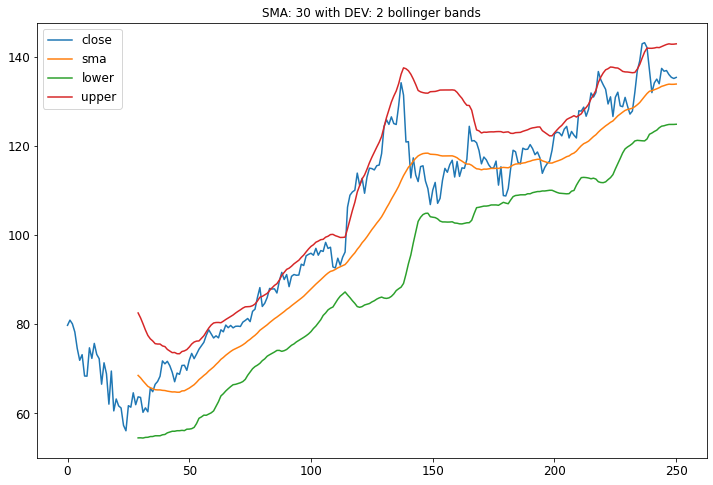

In [12]:
data[['close', 'sma', 'lower', 'upper']] \
    .plot(figsize=(12, 8), title=f'SMA: {SMA} with DEV: {DEV} bollinger bands', fontsize=12)
plt.legend(fontsize=12);

In [13]:
data['distance'] = data['close'] - data['sma']

In [14]:
data['position'] = np.where(data['close'] < data['lower'], 1, np.nan)
# Когда ниже, чем нижняя граница, то недопродана и идем в long

In [15]:
data['position'] = np.where(data['close'] > data['upper'], -1, data['position'])
# Когда выше, чем верхняя граница, то перепродана и идем в short

In [16]:
data['position'] = np.where(data['distance'] * data['distance'].shift(1) < 0, 0, data['position'])
# Когда мы пересекаем sma, то занимаем нейтральную позицию

In [18]:
data['position'] = data['position'].ffill().fillna(0)
# Когда правила не пременимы, то остаемся в предыдущей позиции или нейтральной

In [19]:
data['position'].value_counts()

 0.0    162
-1.0     89
Name: position, dtype: int64